# Sequence to Sequence Attention Translator:
##### Yassin Bahid


## 1 - Introduction:

In the search for a good neural network translator, we study the Sequence 2 sequence model presented in sutskever's paper: https://arxiv.org/abs/1409.3215. we follow the implementation in: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html. We choose the implementation using the attention decoder where the context vector of the sequences is taken in consideration in the decoding.


In [5]:
from torchtext import data
from torchtext.vocab import Vectors
import spacy
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import nltk
# nltk.download('all')
from nltk.tokenize import word_tokenize
from collections import defaultdict
from tqdm import tqdm_notebook
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import time
import os
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import re
import string
import unicodedata
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running On...:', device)
# plt.switch_backend('agg')
import matplotlib.ticker as ticker

Running On...: cuda


## 2 - Data:

Instead of using the pytorcg data set, we use the codex of the euroipean parlement speeches: https://www.statmt.org/europarl/v7. French being my secind language, I chose to study the french english translation. I create a data cleaning object in order to prepare data for the training.




### 2.1 - Cleaning Data:



In [6]:
class DataCleaner:
    def __init__(self,filename):
        '''
        filename: path of the data
        '''
        
        self.path = filename
        self.LoadData()
        self.CleanData()
    def LoadData(self):
        file = open(self.path, mode='rt', encoding='utf-8')
        self.RawText = file.read()
        file.close()
        
    def CleanData(self):
        cleanedData = list()
        
        #changing text into sentences
        self.RawSentences = self.RawText.strip().split('\n')
        ## Regex to filter charachters:
        re_filt = re.compile('[^%s]' % re.escape(string.printable))
        
        ## loading function to delete punctuation:
        table = str.maketrans('', '', string.punctuation)
        for line in self.RawSentences:
            ## Normalizing
            cleanline = unicodedata.normalize('NFD', line).encode('ascii', 'ignore').decode('UTF-8')
            ## Tokenizing:
            cleanline = cleanline.split()
            cleanline = [word.lower() for word in cleanline]
            cleanline =  [word.translate(table) for word in cleanline]
            cleanline = [re_filt.sub('', w) for w in cleanline]
            cleanline = [word for word in cleanline if word.isalpha()]
            cleanedData.append(' '.join(cleanline))
        self.CleanedData = cleanedData

In [7]:
FrenchData = DataCleaner('data/europarl-v7.fr-en.fr').CleanedData

EnglishData = DataCleaner('data/europarl-v7.fr-en.en').CleanedData

In [8]:
## Creating Language Class containing codex:

SOS_token = 0
EOS_token = 1

class Language:
    def __init__(self,name):
        '''
        name: name of the language
        '''
        self.name = name
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.word2count = {}
        self.wordcount = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.wordcount
            self.word2count[word] = 1
            self.index2word[self.wordcount] = word
            self.wordcount += 1
        else:
            self.word2count[word] += 1

In [9]:
## Creating Language Pairs:

eng_prefixes = ["i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ", "I don t", "Do you", "I want", "Are you", "I have", "I think",
       "I can t", "I was", "He is", "I m not", "This is", "I just", "I didn t",
       "I am", "I thought", "I know", "Tom is", "I had", "Did you", "Have you",
       "Can you", "He was", "You don t", "I d like", "It was", "You should",
       "Would you", "I like", "It is", "She is", "You can t", "He has",
       "What do", "If you", "I need", "No one", "You are", "You have",
       "I feel", "I really", "Why don t", "I hope", "I will", "We have",
       "You re not", "You re very", "She was", "I love", "You must", "I can"]
class LangPair():
    def __init__(self, lg1, lg2, Lg1list, Lg2list, max_length = 12):
        self.lg1 = Language(lg1)
        self.lg2 = Language(lg2)
        self.max_length = max_length
        self.ReadLang(Lg1list, Lg2list)
        self.CleanPairs()
        self.AddCorpus()
    
    def ReadLang(self, Lg1list, Lg2list):
        self.Pairs = [[Lg1list[i], Lg2list[i]] for i in range(0, len(Lg1list))]
        self.ReversePairs = [[Lg2list[i], Lg1list[i]] for i in range(0, len(Lg1list))]
    def CleanPairs(self):
        self.Pairs = [pair for pair in self.Pairs if len(pair[0].split(' ')) < self.max_length and \
                                                    len(pair[1].split(' ')) < self.max_length and \
                                                            pair[1].startswith(tuple(eng_prefixes))]
    def AddCorpus(self):
        for pair in self.Pairs:
            self.lg1.addSentence(pair[0])
            self.lg2.addSentence(pair[1])
        print("Counted words:")
        print(self.lg1.name, self.lg1.wordcount)
        print(self.lg2.name, self.lg2.wordcount)

In [11]:
FREN_pairs = LangPair('fr','en', FrenchData, EnglishData)

Counted words:
fr 7009
en 5336


## 3 - Model:

### 3.1 Encoder:
The encoder is a recurent neural netwok that takes in sentences and outputs a vector and a hidden state  for each word. The hidden state is used for the next output.


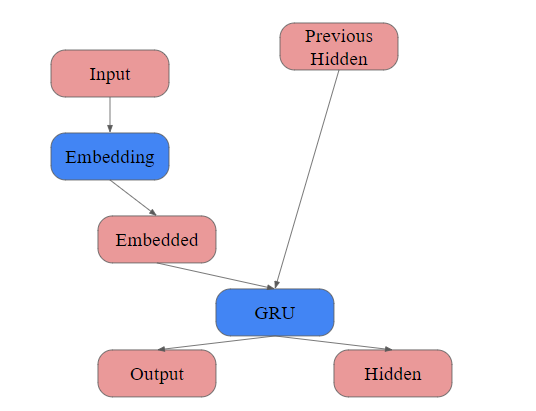



In [12]:
class S2SEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(S2SEncoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


### 3.2 Attention Decoder:

Once the enconding is done, the context vector holds all the information that can be used to decode the word. We add an attention layer that allows the use of different encoders outputs. This layer's wheights will be fitted too to use in the decoding. This layer reflects the interconnectedness of meaning opf a word with the words in the same sentences.

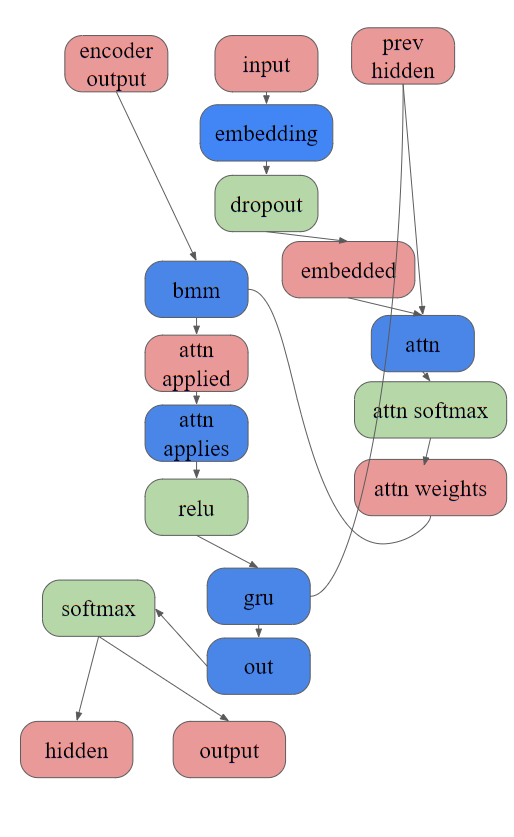



In [13]:
class S2SAttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=12):
        super(S2SAttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 3.3 - Training Function:

In [14]:
def train(input_tensor, 
          target_tensor,
          encoder, 
          decoder, 
          encoder_optimizer, 
          decoder_optimizer, 
          criterion,
          input_lang,
          output_lang,
          teacher_forcing_ratio,
          max_length=12):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    if random.random() < teacher_forcing_ratio:

        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [15]:
def trainIters(encoder, 
               decoder, 
               n_iters,
               input_lang,
               output_lang,
               pairs,
               teacher_forcing_ratio,
               print_every=1000,
               plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adagrad(encoder.parameters())
    decoder_optimizer = optim.Adagrad(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion,input_lang, output_lang, teacher_forcing_ratio)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # showPlot(plot_losses)
    return plot_losses

In [16]:
teacher_forcing_ratio = 0.5
hidden_size = 256
encoder = S2SEncoder(FREN_pairs.lg1.wordcount, hidden_size).to(device)
attn_decoder = S2SAttnDecoder(hidden_size, FREN_pairs.lg2.wordcount, dropout_p=0.1).to(device)

losses = trainIters(encoder, attn_decoder, 75000, FREN_pairs.lg1, FREN_pairs.lg2, FREN_pairs.Pairs, teacher_forcing_ratio, print_every=5000)

1m 18s (- 18m 22s) (5000 6%) 3.6216
2m 30s (- 16m 15s) (10000 13%) 3.3243
3m 42s (- 14m 48s) (15000 20%) 3.1367
4m 55s (- 13m 31s) (20000 26%) 2.9684
6m 7s (- 12m 15s) (25000 33%) 2.8628
7m 20s (- 11m 0s) (30000 40%) 2.7226
8m 34s (- 9m 47s) (35000 46%) 2.6446
9m 46s (- 8m 33s) (40000 53%) 2.5416
10m 59s (- 7m 19s) (45000 60%) 2.4471
12m 12s (- 6m 6s) (50000 66%) 2.3721
13m 25s (- 4m 53s) (55000 73%) 2.3036
14m 39s (- 3m 39s) (60000 80%) 2.2266
15m 53s (- 2m 26s) (65000 86%) 2.1664
17m 7s (- 1m 13s) (70000 93%) 2.1369
18m 21s (- 0m 0s) (75000 100%) 2.0477


### 3.4 - Evaluating the Translator:

While the trainig stays relatively slow, the model trains well. The losses seem to converge to 2.

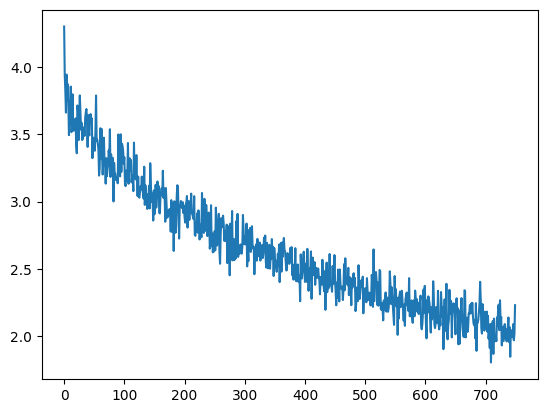

In [17]:
plt.plot([i for i in range(0,len(losses))], losses)
plt.show()

#### 3.4.1 - Translator:

We now code a 

In [28]:
def evaluate(encoder, decoder, sentence, max_length=12):
    with torch.no_grad():
        input_tensor = tensorFromSentence(FREN_pairs.lg1, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(FREN_pairs.lg2.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return ' '.join(decoded_words)

In [38]:
sentences = ["je suis heureux",
            "il est aller en mission",
            "je suis heureux mais il neige"]

for se in sentences:
    print('fr:', se )
    out_se =  evaluate(encoder, attn_decoder, se)
    print('en:', out_se)

fr: je suis heureux
en: i am pleased about that <EOS>
fr: il est aller en mission
en: he is in in a <EOS>
fr: je suis heureux mais il neige
en: i am sorry but i have <EOS>


#### 3.4.2 Final Observations:

The model does well with simple sentences. However, once the senteces get a bit more complicated containing fench "conjunction de coordination", or with an more complicated object, the translator struggles. The translator does not recognize names, especially when coming from arabic or evenr just spanish origins. One possible solution it to create a codex with all name origins for the model to ignore. However, this will inevitably make the Translator slower to train and to use.